In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%load_ext aqueduct.ipython

In [ ]:
%aq_hydra -m eddie.conf -n notebook

In [93]:
import os
import numpy as np
import plotly.express as px
import tqdm.notebook as tqdm
import xarray as xr
import pandas as pd

In [ ]:
import aqueduct as aq

In [ ]:
from eddie.ens10_metar.tasks import VAL_SET, InterpolateMetar

In [ ]:
!echo $EDDIE_LOCAL_STORE

In [ ]:
os.environ['EDDIE_LOCAL_STORE'] = '/gpfswork/rech/ovm/ugd42cy/eddie'
os.environ['MLFLOW_TRACKING_URI'] = 'file:/gpfswork/rech/ovm/ugd42cy/mlflow/store'

In [ ]:
STATION_SET = 'pp2023_medium'

In [ ]:
aq.get_config()

In [ ]:
!echo $MLFLOW_TRACKING_URI

In [ ]:
from pp2023.aqueduct.tasks import ModelPredictions

In [ ]:
preds_task = ModelPredictions(station_set=STATION_SET, run_id='179d2cac3a0f4b758f61f2c233500c8f')

In [ ]:
preds = preds_task.result()

In [ ]:
preds

In [ ]:
obs = []
for d in tqdm.tqdm(sorted(VAL_SET)):
    obs_task = InterpolateMetar(date=d, station_set=STATION_SET)
    obs.append(obs_task.result())

In [ ]:
interpolated_xr = xr.combine_nested(obs, concat_dim='forecast_time')

In [ ]:
interpolated_xr

In [ ]:
preds = preds.sortby('parameter')

In [ ]:
preds

In [ ]:
preds.t2m.argsort(axis=-1)

In [ ]:
preds_sorted_t2m = preds.t2m.isel(parameter=preds.t2m.argsort(axis=-1))
preds_sorted_si10 = preds.si10.isel(parameter=preds.si10.argsort(axis=-1))

In [ ]:
preds = xr.Dataset({'si10': preds_sorted_si10, 't2m': preds_sorted_t2m})

In [ ]:
med_pred = preds.median(dim='parameter')

In [ ]:
np.abs(interpolated_xr.obs_t2m - med_pred.t2m).mean(dim=['station', 'forecast_time'])

In [ ]:
med_forecast = interpolated_xr[['t2m', 'si10']].median(dim='number')

In [ ]:
np.abs(interpolated_xr.obs_si10 - med_pred.si10).mean(dim=['station', 'forecast_time'])

In [ ]:
np.abs(interpolated_xr.obs_t2m - med_pred.t2m).mean(dim=['station', 'forecast_time'])

In [ ]:
np.abs(interpolated_xr.obs_si10 - med_forecast.si10).mean(dim=['station', 'forecast_time'])

In [ ]:
np.abs(interpolated_xr.obs_t2m - med_forecast.t2m).mean(dim=['station', 'forecast_time'])

In [ ]:
preds['obs_t2m'] = interpolated_xr.obs_t2m

In [ ]:
preds

In [ ]:
t2m_df = preds[['obs_t2m', 't2m']].to_dataframe()

In [ ]:
t2m_df_sample = t2m_df[~np.isnan(t2m_df['obs_t2m'])].groupby(['forecast_time', 'step', 'station']).median()

In [ ]:
t2m_df_sample

In [ ]:
t2m_df_sample

In [ ]:
px.scatter(data_frame=t2m_df_sample, x='obs_t2m', y='t2m', opacity=0.1, width=1000, height=1000)

In [ ]:
preds['obs_si10'] = interpolated_xr.obs_si10
si10_df = preds[['obs_si10', 'si10']].to_dataframe().groupby(['forecast_time', 'step', 'station']).median()
si10_df_sample = si10_df[~np.isnan(si10_df['obs_si10'])]

In [ ]:
px.scatter(data_frame=si10_df_sample, x='obs_si10', y='si10', opacity=0.1, width=1000, height=1000)

## Calibration plot

In [ ]:
preds.t2m.sizes

In [ ]:
preds.t2m

In [ ]:
obs_t2m = interpolated_xr['obs_t2m']

In [ ]:
preds.t2m < obs_t2m

In [ ]:
def calibration_plot(ensemble_forecast, obs, ensemble_dim='parameter'):
    ensemble_size = ensemble_forecast.sizes[ensemble_dim] + 1
    
    counts = (ensemble_forecast < obs).sum(dim=ensemble_dim)
    
    counts_df = counts.to_dataframe(name='count')
    obs_df = obs.to_dataframe(name='obs')['obs']
    
    counts_df = counts_df[~np.isnan(obs_df)]
    
    bar_values = counts_df['count'].value_counts().sort_index()

    fig = px.bar(x=bar_values.index, y=bar_values, width=800)
    fig.add_hline(y=bar_values.sum() * (1/ensemble_size), annotation_text='Perfect calibration')
    return fig

In [ ]:
calibration_plot(preds.t2m, obs_t2m)

In [ ]:
obs_si10 = interpolated_xr.obs_si10

In [ ]:
calibration_plot(preds.si10, obs_si10)

In [ ]:
calibration_plot(interpolated_xr.t2m, interpolated_xr.obs_t2m, ensemble_dim='number')

In [ ]:
calibration_plot(interpolated_xr.si10, interpolated_xr.obs_si10, ensemble_dim='number')

## Investigate wind @ 0

In [ ]:
obs_si10_df = obs_si10.to_dataframe()

In [ ]:
px.histogram(obs_si10_df['obs_si10'])

In [ ]:
obs_si10_df['obs_si10']

In [ ]:
obs_si10_df[obs_si10_df['obs_si10'] == 0.0].groupby(['station']).count()['obs_si10'].sort_values()

In [ ]:
vuj = obs_si10_df.xs(level='station', key='VUJ')['obs_si10']

In [ ]:
px.line(data_frame=vuj.reset_index(), x='forecast_time', y='obs_si10')

In [ ]:
cyph = obs_si10_df.xs(level='station', key='CYPH')['obs_si10']

In [ ]:
px.line(data_frame=cyph.reset_index(), x='forecast_time', y='obs_si10')

In [ ]:
obs_si10_df[obs_si10_df['obs_si10'] > 30]

## CRPS

In [ ]:
import properscoring

In [ ]:
mask = np.isnan(obs_si10.values)

In [66]:
preds = preds.compute()

In [112]:
raw_si10 = interpolated_xr.si10.compute()

In [116]:
raw_si10 = raw_si10.transpose('forecast_time', 'step', 'station', 'number')

In [ ]:
mask = np.isnan(obs_si10)
properscoring.crps_ensemble(obs_si10.values, preds.si10).mean(axis=2).mean(axis=0)

In [117]:
si10_crps = properscoring.crps_ensemble(obs_si10.values, preds.si10)
si10_crps_raw = properscoring.crps_ensemble(obs_si10.values, raw_si10)

In [119]:
si10_crps_xr = xr.DataArray(si10_crps, dims=['forecast_time', 'step', 'station'], coords=obs_si10.coords)
raw_si10_crps_xr = xr.DataArray(si10_crps_raw, dims=['forecast_time', 'step', 'station'], coords=obs_si10.coords)

si10_crps = xr.Dataset({'model_si10_crps': si10_crps_xr, 'raw_si10_crps': raw_si10_crps_xr})

In [120]:
si10_crps.to_dataframe()

latitude  longitude forecast_valid  \
forecast_time step   station                                       
1998-01-29    0 days 5C1          29.5      261.5     1998-01-29   
                     ACK          41.5      290.0     1998-01-29   
                     ACV          41.0      236.0     1998-01-29   
                     AFW          33.0      262.5     1998-01-29   
                     AGC          40.5      280.0     1998-01-29   
...                                ...        ...            ...   
2014-12-31    2 days SOW          34.5      250.0     2015-01-02   
                     TEW          42.5      275.5     2015-01-02   
                     TLH          30.5      275.5     2015-01-02   
                     VUJ          35.5      280.0     2015-01-02   
                     WLD          37.0      263.0     2015-01-02   

                              model_si10_crps  raw_si10_crps  
forecast_time step   station                                  
1998-01-29    0 days 5C1                  NaN            NaN  
                     ACK            12.971860       4.067212  
                     ACV                  NaN            NaN  
                     AFW             0.652989       0.323276  
                     AGC             0.286564       0.496770  
...                                       ...            ...  
2014-12-31    2 days SOW             0.226426       0.148269  
                     TEW             1.034070       0.858817  
                     TLH             0.590078       0.257485  
                     VUJ             1.486257       1.001534  
                     WLD             0.397272       0.259912  

[71400 rows x 5 columns]

In [67]:
obs_si10_df = obs_si10.to_dataframe()
preds_si10_df = preds.si10.to_dataframe()

In [121]:
mask = np.isnan(obs_si10_df['obs_si10'])

In [122]:
si10_crps_df = si10_crps.to_dataframe()[~mask]

In [123]:
si10_crps_df

latitude  longitude forecast_valid  \
forecast_time step   station                                       
1998-01-29    0 days ACK          41.5      290.0     1998-01-29   
                     AFW          33.0      262.5     1998-01-29   
                     AGC          40.5      280.0     1998-01-29   
                     ANW          42.5      260.0     1998-01-29   
                     APA          39.5      255.0     1998-01-29   
...                                ...        ...            ...   
2014-12-31    2 days SOW          34.5      250.0     2015-01-02   
                     TEW          42.5      275.5     2015-01-02   
                     TLH          30.5      275.5     2015-01-02   
                     VUJ          35.5      280.0     2015-01-02   
                     WLD          37.0      263.0     2015-01-02   

                              model_si10_crps  raw_si10_crps  
forecast_time step   station                                  
1998-01-29    0 days ACK            12.971860       4.067212  
                     AFW             0.652989       0.323276  
                     AGC             0.286564       0.496770  
                     ANW             0.554156       2.220484  
                     APA             2.459770       4.568499  
...                                       ...            ...  
2014-12-31    2 days SOW             0.226426       0.148269  
                     TEW             1.034070       0.858817  
                     TLH             0.590078       0.257485  
                     VUJ             1.486257       1.001534  
                     WLD             0.397272       0.259912  

[63969 rows x 5 columns]

### Various plots

In [125]:
crps_by_step = si10_crps_df.groupby(['step']).mean()
crps_by_step

,latitude,longitude,forecast_valid,model_si10_crps,raw_si10_crps
step,,,,,
0 days,48.799421,257.449808,2006-12-04 21:10:41.704035840,1.035286,1.614335
1 days,48.737732,257.330238,2006-11-29 03:59:28.339804416,1.042476,1.397929
2 days,48.693306,257.302138,2006-12-13 03:05:26.283987968,1.065520,1.394330


,step,variable,value
0,0 days,model_si10_crps,1.035286
1,1 days,model_si10_crps,1.042476
2,2 days,model_si10_crps,1.065520
3,0 days,raw_si10_crps,1.614335
4,1 days,raw_si10_crps,1.397929
5,2 days,raw_si10_crps,1.394330


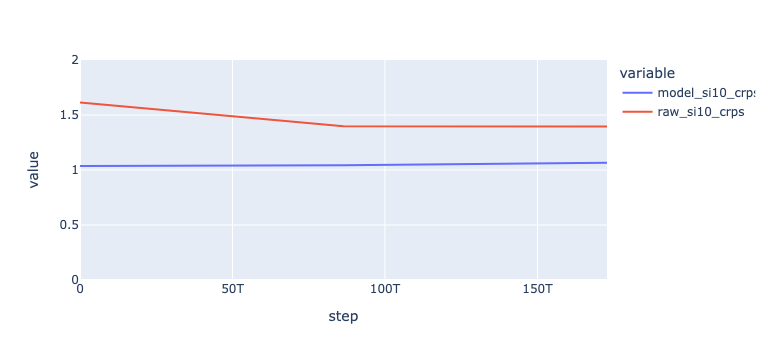

In [129]:
by_step_melt = crps_by_step.reset_index().melt(id_vars=['step'], value_vars=['model_si10_crps', 'raw_si10_crps'])
px.line(data_frame=by_step_melt.reset_index(), x='step', y='value', color='variable', range_y=(0, 2))

In [130]:
by_year_month

forecast_time
1998-01-31    1.071556
1998-02-28         NaN
1998-03-31    1.410168
1998-04-30    1.361621
1998-05-31    1.113303
                ...   
2014-08-31    0.869226
2014-09-30    0.924370
2014-10-31    0.953197
2014-11-30    0.929224
2014-12-31    1.090070
Freq: M, Name: si10_crps, Length: 204, dtype: float32

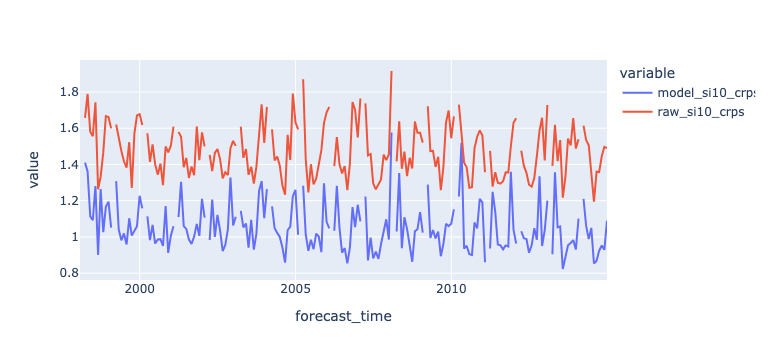

In [131]:
by_year_month = si10_crps_df.reset_index().set_index('forecast_time')[['model_si10_crps', 'raw_si10_crps']].groupby(pd.Grouper(freq="M")).mean()
by_year_month_melt = by_year_month.reset_index().melt(id_vars=['forecast_time'], value_vars=['model_si10_crps', 'raw_si10_crps'])
px.line(data_frame=by_year_month_melt, x='forecast_time', y='value', color='variable')

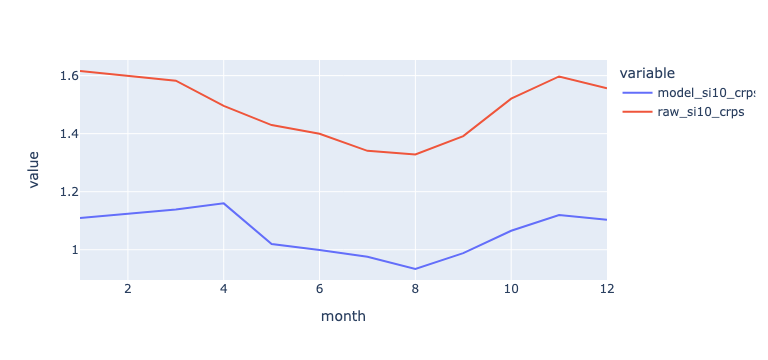

In [132]:
si10_crps_df['month'] = si10_crps_df.index.get_level_values(level='forecast_time').month
by_month = si10_crps_df[['month', 'model_si10_crps', 'raw_si10_crps']].groupby('month').mean()
by_month_melt = by_month.reset_index().melt(id_vars=['month'], value_vars=['model_si10_crps', 'raw_si10_crps'])


px.line(data_frame=by_month_melt, x='month', y='value', color='variable')

In [136]:
by_station = si10_crps_df[['model_si10_crps', 'raw_si10_crps']].groupby('station').mean().sort_values('model_si10_crps', ascending=False)

In [138]:
by_station
by_station_melt = by_station.reset_index().melt(id_vars=['station'], value_vars=['model_si10_crps', 'raw_si10_crps'])

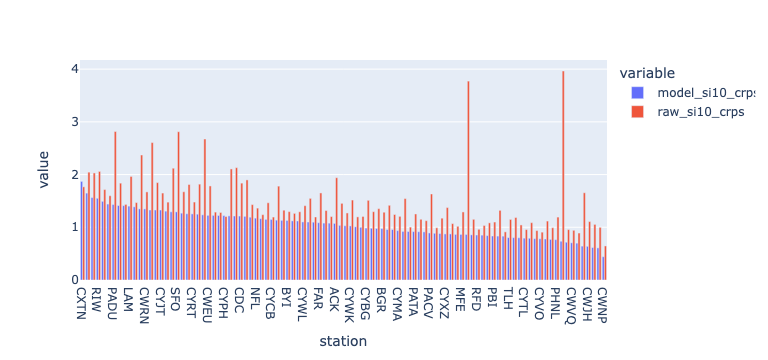

In [140]:
px.bar(data_frame=by_station_melt, x='station', y='value', color='variable', barmode='group')

## Now for temperature

In [141]:
obs_t2m = interpolated_xr.obs_t2m.compute()
raw_t2m = interpolated_xr.t2m.compute()
model_t2m = preds.t2m.compute()

In [143]:
raw_t2m = raw_t2m.transpose('forecast_time', 'step', 'station', 'number')

In [147]:
model_crps_np = properscoring.crps_ensemble(obs_t2m, model_t2m)
raw_crps_np = properscoring.crps_ensemble(obs_t2m, raw_t2m)

In [148]:
model_crps_np.shape

(238, 3, 100)

In [153]:
t2m_crps_xr = xr.Dataset({
    'model_t2m_crps': xr.DataArray(model_crps_np, dims=['forecast_time', 'step', 'station']),
    'raw_t2m_crps': xr.DataArray(raw_crps_np, dims=['forecast_time', 'step', 'station']),
    'obs_t2m': obs_t2m
}, coords=model_t2m.coords)

In [156]:
t2m_crps_df = t2m_crps_xr.to_dataframe()
mask = np.isnan(t2m_crps_df['obs_t2m'])
t2m_crps_df = t2m_crps_df[~mask]

In [157]:
t2m_crps_df

model_t2m_crps  raw_t2m_crps  latitude  \
forecast_time step   station                                           
1998-01-29    0 days ACK            0.326208      0.016674      41.5   
                     AFW            0.688249      0.555249      33.0   
                     AGC            0.263305      0.160013      40.5   
                     ANW            0.375827      0.441447      42.5   
                     APA            0.868973      1.504280      39.5   
...                                      ...           ...       ...   
2014-12-31    2 days SOW            0.332202      1.525977      34.5   
                     TEW            0.310300      0.095385      42.5   
                     TLH            2.397965      4.385309      30.5   
                     VUJ            0.512724      0.133491      35.5   
                     WLD            0.466926      0.794319      37.0   

                              longitude forecast_valid     obs_t2m  
forecast_time step   station                                        
1998-01-29    0 days ACK          290.0     1998-01-29  277.549988  
                     AFW          262.5     1998-01-29  289.250000  
                     AGC          280.0     1998-01-29  278.149994  
                     ANW          260.0     1998-01-29  276.149994  
                     APA          255.0     1998-01-29  277.149994  
...                                 ...            ...         ...  
2014-12-31    2 days SOW          250.0     2015-01-02  267.149994  
                     TEW          275.5     2015-01-02  269.850006  
                     TLH          275.5     2015-01-02  289.850006  
                     VUJ          280.0     2015-01-02  277.750000  
                     WLD          263.0     2015-01-02  272.049988  

[63969 rows x 6 columns]

In [169]:
wld = t2m_crps_df.xs(level='station', key='WLD')
wld_melt = wld.reset_index().melt(id_vars=['forecast_time', 'obs_t2m'], value_vars=['model_t2m_crps', 'raw_t2m_crps'])

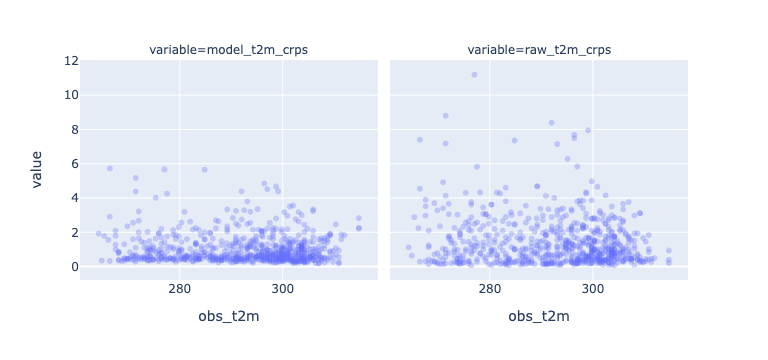

In [170]:
px.scatter(data_frame=wld_melt, x='obs_t2m', y='value', facet_col='variable', opacity=0.3)

In [171]:

VALUE_VARS = ['model_t2m_crps', 'raw_t2m_crps']

In [174]:
by_step = t2m_crps_df.groupby('step').mean().reset_index().melt(id_vars=['step'], value_vars=VALUE_VARS)

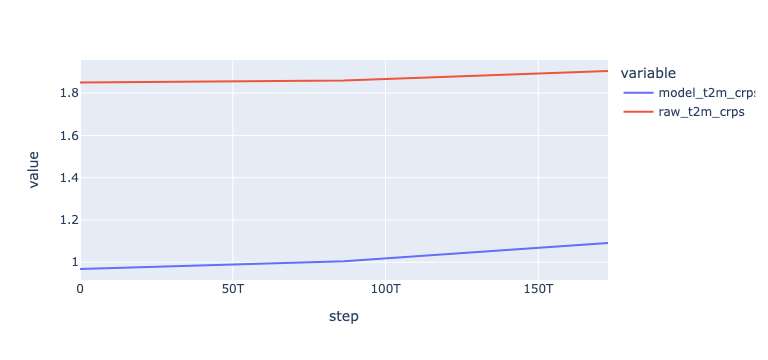

In [176]:
px.line(data_frame=by_step, x='step', y='value', color='variable')

In [177]:
t2m_crps_df['month'] = t2m_crps_df.index.get_level_values('forecast_time').month

In [178]:
by_month = t2m_crps_df.groupby('month').mean().reset_index().melt(id_vars=['month'], value_vars=VALUE_VARS)

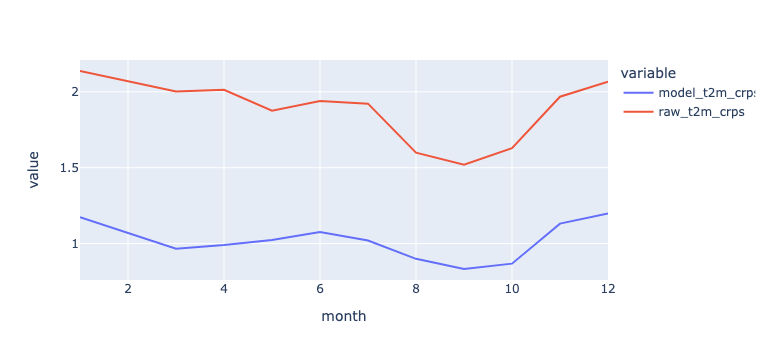

In [181]:
px.line(data_frame=by_month, x='month', y='value', color='variable')

In [ ]:
.melt(id_vars=['station'], value_vars=VALUE_VARS)


In [186]:
by_station = t2m_crps_df.groupby('station').mean().reset_index()
by_station = by_station.sort_values('model_t2m_crps')
by_station = by_station.reset_index().melt(id_vars=['station'], value_vars=VALUE_VARS)

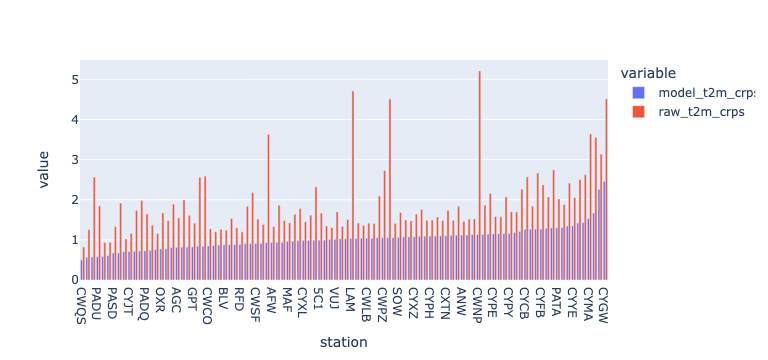

In [189]:
px.bar(data_frame=by_station, x='station', y='value', color='variable', barmode='group')